In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
# import stuff
import sys,os,os.path

sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
import core.functions as func

In [103]:
def plot_2Dhist(ND_array, xlabel, ylabel, title = '2D Histogram', xlabel_title = 'x axis', ylabel_title = 'y axis'):
    '''
    ND_array -> input array of NxN dimensions. MAKE SURE ITS NUMPY HSTACKED ARRAY
    xlabel   -> x label list
    ylabel   -> y label list

    To make array suitable for input use function similar to this:
    array = np.hstack((array_1, array_2, array_3, array_4, array_5, array_6)).reshape(-1,array_1.shape[0])
    '''


    nx, ny = ND_array.shape

    indx, indy = np.arange(ny), np.arange(nx)
    x, y = np.meshgrid(indx, indy, indexing='ij')

    fig, ax = plt.subplots()
    ax.imshow(ND_array, interpolation="none")

    col_split = np.min(ND_array) + ((np.max(ND_array) - np.min(ND_array)) / 2)
    print(np.min(ND_array), np.max(ND_array))
    print(col_split)

    for xval, yval in zip(y.flatten(), x.flatten()):
        zval = ND_array[xval, yval]
        t = zval # format value with 1 decimal point
        c = 'k' if zval > col_split else 'w' # if dark-green, change text color to white
        ax.text(yval, xval, t, color=c, va='center', ha='center')


    xlabels = xlabel
    ylabels = ylabel

    ax.set_xticks(indx+0.5) # offset x/y ticks so gridlines run on border of boxes
    ax.set_yticks(indy+0.5)
    ax.grid(ls='-', lw=2)
    ax.set_xlabel(xlabel_title)
    ax.set_ylabel(ylabel_title)
    ax.set_title(title)

    # the tick labels, if you want them centered need to be adjusted in 
    # this special way.
    for a, ind, labels in zip((ax.xaxis, ax.yaxis), (indx, indy), 
                            (xlabels, ylabels)):
        a.set_major_formatter(ticker.NullFormatter())
        a.set_minor_locator(ticker.FixedLocator(ind))
        a.set_minor_formatter(ticker.FixedFormatter(labels))

    ax.xaxis.tick_top()

# It works! Functionalise
def scrape_FOM_data(data_path):

    # collect data
    hold = pd.HDFStore(data_path)
    store = hold.keys()
    hold.close()

    # sanitise
    remove = [x.replace("/", "") for x in store]
    split = [(x.split("_")) for x in remove]

    # collect all unique first elements (n_iter)
    unique_0s = list(set([x[0] for i, x in enumerate(split)]))
    # and second elements
    unique_1s = list(set([x[1] for i, x in enumerate(split)]))

    # organise and add leading zero to column (1s)
    unique_0s_ = sorted(unique_0s, key=float)
    unique_1s_ = sorted(unique_1s, key=float)
    unique_1s_ = ["n_iter"] + unique_1s_
    
    # create pandas dataframe with these as the axis
    df = pd.DataFrame(columns = unique_1s_)
    
    # start adding rows babee
    for i in range(len(unique_0s_)):
    	df.loc[i] = [unique_0s_[i]] + list(np.full(shape=len(unique_1s), fill_value=np.nan))

    # set it as the index as well
    df.set_index('n_iter', inplace=True)
    
    # collect the data from each table in the h5 dataframe
    for i in range(len(store)):
        # reformat store data to allow for correct indexing
        remove = store[i].replace("/", "")
        split = remove.split("_")

        play_thing = pd.read_hdf(data_path,key=store[i])
        play_thing.set_index('Cut', inplace=True)
        fom_val = play_thing.loc['FOM_MAX - blob2_E_val (MeV)', 'Relative Efficiency']
            
        df.at[split[0], split[1]] = fom_val
	
    fom_list = []
    for i in range(len(df.index)):
        fom_list.append(df.loc[df.index[i]].to_numpy())
    
    fom_list = np.array(fom_list)
    #reshape into x,y array
    x_vals = (df.columns).to_list()
    y_vals = (df.index).to_list()
    
    # set nans to zeros
    fom_list[np.isnan(fom_list.astype(float))] = 0
    
    fom_list = np.round(fom_list.astype(float), decimals=2)
    
    plot_2Dhist(fom_list, x_vals, y_vals, title = 'FOM LPR', xlabel_title = 'e_cut', ylabel_title = 'number of iterations')
    


# this one differs, it allows you to scrape any data and make a 2D FOM plot
def scrape_any_data(data_path, string_1, string_2, plot_title):
    '''
    string 1 and 2 define the names of the row and columns you
    wish to select in your h5 file
    '''

    # collect data
    hold = pd.HDFStore(data_path)
    store = hold.keys()
    hold.close()

    # sanitise
    remove = [x.replace("/", "") for x in store]
    split = [(x.split("_")) for x in remove]

    # collect all unique first elements (n_iter)
    unique_0s = list(set([x[0] for i, x in enumerate(split)]))
    # and second elements
    unique_1s = list(set([x[1] for i, x in enumerate(split)]))

    # organise and add leading zero to column (1s)
    unique_0s_ = sorted(unique_0s, key=float)
    unique_1s_ = sorted(unique_1s, key=float)
    unique_1s_ = ["n_iter"] + unique_1s_
    
    # create pandas dataframe with these as the axis
    df = pd.DataFrame(columns = unique_1s_)
    
    # start adding rows babee
    for i in range(len(unique_0s_)):
    	df.loc[i] = [unique_0s_[i]] + list(np.full(shape=len(unique_1s), fill_value=np.nan))

    # set it as the index as well
    df.set_index('n_iter', inplace=True)
    
    # collect the data from each table in the h5 dataframe
    for i in range(len(store)):
        # reformat store data to allow for correct indexing
        remove = store[i].replace("/", "")
        split = remove.split("_")

        play_thing = pd.read_hdf(data_path,key=store[i])
        play_thing.set_index('Cut', inplace=True)
        fom_val = play_thing.loc[str(string_1), str(string_2)]
            
        df.at[split[0], split[1]] = fom_val
	
    fom_list = []
    for i in range(len(df.index)):
        fom_list.append(df.loc[df.index[i]].to_numpy())
    
    fom_list = np.array(fom_list)
    #reshape into x,y array
    x_vals = (df.columns).to_list()
    y_vals = (df.index).to_list()
    
    # set nans to zeros
    fom_list[np.isnan(fom_list.astype(float))] = 0
    
    fom_list = np.round(fom_list.astype(float), decimals=2)
    
    plot_2Dhist(fom_list, x_vals, y_vals, title = str(plot_title), xlabel_title = 'number of iterations', ylabel_title = 'e_cut')

In [46]:
def sanitise_array(df):
    '''
    sanitises the dataframe passed through from the csv
    '''
    # rewrite index
    df = df.set_index([pd.Index(data_test['Cut'].to_list())])
    df = df.drop(data_test.columns[0], axis = 1)

    return df



In [5]:
data_dir = '/home/e78368jw/Downloads/tmp_out/testing_arena/satkill_comparisons/'

files = ['eff_lEk_sk.csv',
         'eff_lEk_nsk.csv',
         'eff_nlEk_sk.csv',
         'eff_nlEk_nsk.csv']

In [43]:
# load in the data
files
data_array = {}

for i in files:
    print("Collecting file: {}".format(i))
    data_array[(str(i)[:-4])] = pd.read_csv(data_dir + i, index_col=[0])

display(data_array)

{'eff_lEk_sk':                            Cut  Relative Efficiency  Relative Events  \
 0                      No cuts           100.000000         87220.00   
 1                Fiducial Cuts            46.187801         40285.00   
 2                One track cut            64.187663         25858.00   
 3            Blob overlap cuts            78.610101         20327.00   
 4                  Energy cuts             8.865056          1802.00   
 5            pos_evt - all_evt          1128.000000          1802.00   
 6  FOM_MAX - blob2_E_val (MeV)             2.386616             0.28   
 7        trk_no - satellite_no        201268.000000         60397.00   
 
    Single Cut Efficiency  
 0             100.000000  
 1              46.187801  
 2              57.971795  
 3              71.293281  
 4               5.787663  
 5               0.000000  
 6               0.000000  
 7               0.000000  ,
 'eff_lEk_nsk':                            Cut  Relative Efficiency  Relat

In [44]:
display(data_array['eff_lEk_sk'])

,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,87220.00,100.000000
1,Fiducial Cuts,46.187801,40285.00,46.187801
2,One track cut,64.187663,25858.00,57.971795
3,Blob overlap cuts,78.610101,20327.00,71.293281
4,Energy cuts,8.865056,1802.00,5.787663
5,pos_evt - all_evt,1128.000000,1802.00,0.000000
6,FOM_MAX - blob2_E_val (MeV),2.386616,0.28,0.000000
7,trk_no - satellite_no,201268.000000,60397.00,0.000000


In [28]:
for key in data_array:
    print(key)
    display(data_array[key])

eff_lEk_sk


,Unnamed: 0,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,0,No cuts,100.000000,87220.00,100.000000
1,1,Fiducial Cuts,46.187801,40285.00,46.187801
2,2,One track cut,64.187663,25858.00,57.971795
3,3,Blob overlap cuts,78.610101,20327.00,71.293281
4,4,Energy cuts,8.865056,1802.00,5.787663
5,5,pos_evt - all_evt,1128.000000,1802.00,0.000000
6,6,FOM_MAX - blob2_E_val (MeV),2.386616,0.28,0.000000
7,7,trk_no - satellite_no,201268.000000,60397.00,0.000000


eff_lEk_nsk


,Unnamed: 0,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,0,No cuts,100.000000,87004.00,100.000000
1,1,Fiducial Cuts,46.248448,40238.00,46.248448
2,2,One track cut,66.409861,26722.00,60.061606
3,3,Blob overlap cuts,78.673004,21023.00,70.970300
4,4,Energy cuts,9.660848,2031.00,6.175578
5,5,pos_evt - all_evt,1241.000000,2031.00,0.000000
6,6,FOM_MAX - blob2_E_val (MeV),2.438495,0.28,0.000000
7,7,trk_no - satellite_no,332380.000000,197928.00,0.000000


eff_nlEk_sk


,Unnamed: 0,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,0,No cuts,100.000000,87225.00,100.000000
1,1,Fiducial Cuts,43.548295,37985.00,43.548295
2,2,One track cut,48.742925,18515.00,43.922041
3,3,Blob overlap cuts,84.012962,15555.00,71.369447
4,4,Energy cuts,9.765349,1519.00,5.787332
5,5,pos_evt - all_evt,958.000000,1519.00,0.000000
6,6,FOM_MAX - blob2_E_val (MeV),2.314615,0.28,0.000000
7,7,trk_no - satellite_no,201268.000000,0.00,0.000000


eff_nlEk_nsk


,Unnamed: 0,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,0,No cuts,100.000000,87009.0,100.000000
1,1,Fiducial Cuts,41.184245,35834.0,41.184245
2,2,One track cut,23.095384,8276.0,20.833477
3,3,Blob overlap cuts,95.360077,7892.0,72.543070
4,4,Energy cuts,20.527116,1620.0,6.175223
5,5,pos_evt - all_evt,1002.000000,1620.0,0.000000
6,6,FOM_MAX - blob2_E_val (MeV),2.612587,0.3,0.000000
7,7,trk_no - satellite_no,332380.000000,0.0,0.000000


In [45]:
# sanitise, remove first column
data_test = data_array['eff_nlEk_nsk']
#data_test = data_test.drop(data_test.columns[0], axis=1)

# eliminate the index
data_test = data_test.set_index([pd.Index(data_test['Cut'].to_list())])
data_test = data_test.drop(data_test.columns[0], axis = 1)

display(data_test)
select_col = 'Relative Efficiency'
select_row = 'pos_evt - all_evt'

# access specific value you want
pos_evts = data_test.at[select_row, select_col]
print(pos_evts)


,Relative Efficiency,Relative Events,Single Cut Efficiency
No cuts,100.000000,87009.0,100.000000
Fiducial Cuts,41.184245,35834.0,41.184245
One track cut,23.095384,8276.0,20.833477
Blob overlap cuts,95.360077,7892.0,72.543070
Energy cuts,20.527116,1620.0,6.175223
pos_evt - all_evt,1002.000000,1620.0,0.000000
FOM_MAX - blob2_E_val (MeV),2.612587,0.3,0.000000
trk_no - satellite_no,332380.000000,0.0,0.000000


1002.0


In [47]:
data_test = data_array['eff_nlEk_nsk']
display(data_test)
display(sanitise_array(data_test))

,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,87009.0,100.000000
1,Fiducial Cuts,41.184245,35834.0,41.184245
2,One track cut,23.095384,8276.0,20.833477
3,Blob overlap cuts,95.360077,7892.0,72.543070
4,Energy cuts,20.527116,1620.0,6.175223
5,pos_evt - all_evt,1002.000000,1620.0,0.000000
6,FOM_MAX - blob2_E_val (MeV),2.612587,0.3,0.000000
7,trk_no - satellite_no,332380.000000,0.0,0.000000


,Relative Efficiency,Relative Events,Single Cut Efficiency
No cuts,100.000000,87009.0,100.000000
Fiducial Cuts,41.184245,35834.0,41.184245
One track cut,23.095384,8276.0,20.833477
Blob overlap cuts,95.360077,7892.0,72.543070
Energy cuts,20.527116,1620.0,6.175223
pos_evt - all_evt,1002.000000,1620.0,0.000000
FOM_MAX - blob2_E_val (MeV),2.612587,0.3,0.000000
trk_no - satellite_no,332380.000000,0.0,0.000000


 PLEASE SANITY CHECK THIS FIRST BEFORE TRUSTING OUTPUT!
Reading in eff_lEk_sk...
lEk_sk
1128.0
Reading in eff_lEk_nsk...
lEk_nsk
1241.0
Reading in eff_nlEk_sk...
nlEk_sk
958.0
Reading in eff_nlEk_nsk...
nlEk_nsk
1002.0
958.0 1241.0
1099.5


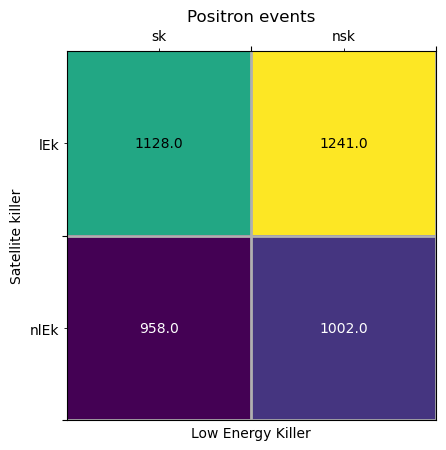

In [104]:

print("================================================")
print(" PLEASE SANITY CHECK THIS FIRST BEFORE TRUSTING OUTPUT!")
print("================================================")


hist_list = []
x_vals = []
y_vals = []
select_col = 'Relative Efficiency'
select_row = 'pos_evt - all_evt'

timer = 0
for keys in data_array:
    print("Reading in {}...".format(keys))
    read_data = sanitise_array(data_array[keys])
    # removing the first 4 components from any given list

    mode = keys[4:]
    print(mode)
    mode = mode.split("_")
    x_vals.append(mode[1])
    y_vals.append(mode[0])
    
    rel_data = read_data.at[select_row, select_col]
    print(rel_data)
    hist_list.append(rel_data)


# remove duplicates in x and y labels
x_vals = list(dict.fromkeys(x_vals))
y_vals = list(dict.fromkeys(y_vals))
hist_arr = np.reshape(np.array(hist_list), (-1, 2))

plot_2Dhist(hist_arr, x_vals, y_vals, title = "Positron events", xlabel_title = 'Low Energy Killer', ylabel_title = 'Satellite killer')



In [94]:
def plot_comparisons(data_array, select_row, select_col, title = '2D histogram', xlabel = 'x label', ylabel = 'y label', verbose = True):
    '''
    Select row and col based on dataframe you're passing in
    sanitises and output 2D hist based on results you want
    '''
    if (verbose == True):
        print("================================================")
        print(" PLEASE SANITY CHECK THIS FIRST BEFORE TRUSTING OUTPUT!")
        print("================================================")


    hist_list = []
    x_vals = []
    y_vals = []

    timer = 0
    for keys in data_array:
        
        
        read_data = sanitise_array(data_array[keys])
        # removing the first 4 components from any given list

        mode = keys[4:]
        
        mode = mode.split("_")
        x_vals.append(mode[1])
        y_vals.append(mode[0])
        
        rel_data = round(read_data.at[select_row, select_col], 3)
        hist_list.append(rel_data)

        if (verbose == True):
            print("Reading in {}...".format(keys))
            print(mode[0], mode[1])
            print(rel_data)


    # remove duplicates in x and y labels
    x_vals = list(dict.fromkeys(x_vals))
    y_vals = list(dict.fromkeys(y_vals))
    hist_arr = np.reshape(np.array(hist_list), (-1, 2))

    plot_2Dhist(hist_arr, x_vals, y_vals, title = title, xlabel_title = xlabel, ylabel_title = ylabel)



In [86]:
print("Take a value from 'Cut' colum and one column headers to get a cell value from all 4 dfs")
display(data_array['eff_lEk_sk'])

Take a value from 'Cut' colum and one column headers to get a cell value from all 4 dfs


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,87220.00,100.000000
1,Fiducial Cuts,46.187801,40285.00,46.187801
2,One track cut,64.187663,25858.00,57.971795
3,Blob overlap cuts,78.610101,20327.00,71.293281
4,Energy cuts,8.865056,1802.00,5.787663
5,pos_evt - all_evt,1128.000000,1802.00,0.000000
6,FOM_MAX - blob2_E_val (MeV),2.386616,0.28,0.000000
7,trk_no - satellite_no,201268.000000,60397.00,0.000000


 PLEASE SANITY CHECK THIS FIRST BEFORE TRUSTING OUTPUT!
Reading in eff_lEk_sk...
lEk sk
1128.0
Reading in eff_lEk_nsk...
lEk nsk
1241.0
Reading in eff_nlEk_sk...
nlEk sk
958.0
Reading in eff_nlEk_nsk...
nlEk nsk
1002.0
958.0 1241.0
1099.5


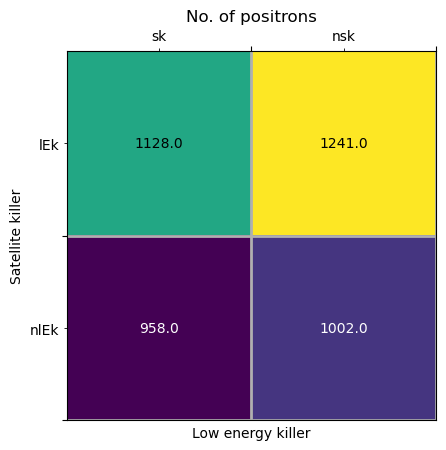

In [105]:
plot_comparisons(data_array, 'pos_evt - all_evt', 'Relative Efficiency', title = 'No. of positrons', xlabel = 'Low energy killer', ylabel = 'Satellite killer')

1519.0 2031.0
1775.0


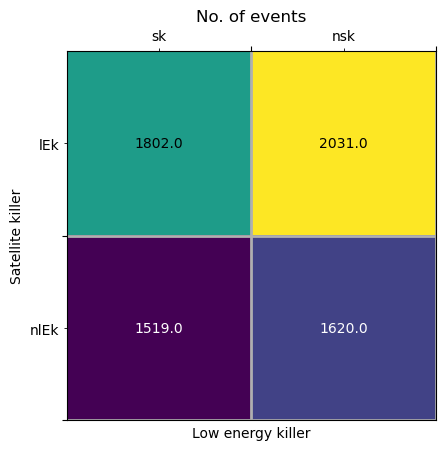

In [106]:
plot_comparisons(data_array, 'pos_evt - all_evt', 'Relative Events', title = 'No. of events', xlabel = 'Low energy killer', ylabel = 'Satellite killer', verbose = False)

0.611 0.631
0.621


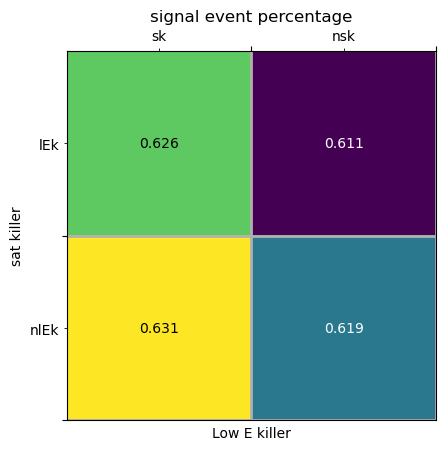

In [107]:
hist_list = []
x_vals = []
y_vals = []

timer = 0
for keys in data_array:
    
    
    read_data = sanitise_array(data_array[keys])
    # removing the first 4 components from any given list

    mode = keys[4:]
    
    mode = mode.split("_")
    x_vals.append(mode[1])
    y_vals.append(mode[0])
    
    sig_no = read_data.at['pos_evt - all_evt', 'Relative Efficiency']
    total_no = read_data.at['pos_evt - all_evt', 'Relative Events']
    rel_data = round(sig_no/total_no,3)
    hist_list.append(rel_data)


# remove duplicates in x and y labels
x_vals = list(dict.fromkeys(x_vals))
y_vals = list(dict.fromkeys(y_vals))
hist_arr = np.reshape(np.array(hist_list), (-1, 2))

plot_2Dhist(hist_arr, x_vals, y_vals, title = "signal event percentage", xlabel_title = "Low E killer", ylabel_title = "sat killer")


2.315 2.613
2.464


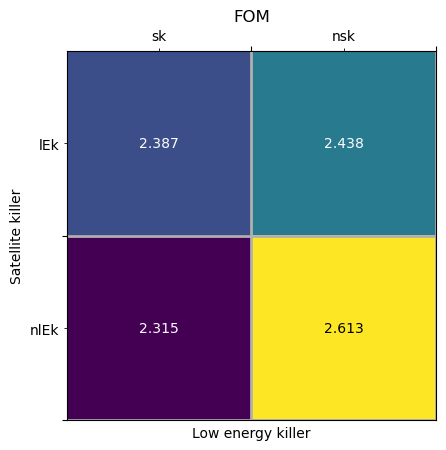

In [108]:
plot_comparisons(data_array, 'FOM_MAX - blob2_E_val (MeV)', 'Relative Efficiency', title = 'FOM', xlabel = 'Low energy killer', ylabel = 'Satellite killer', verbose = False)

23.095 66.41
44.7525


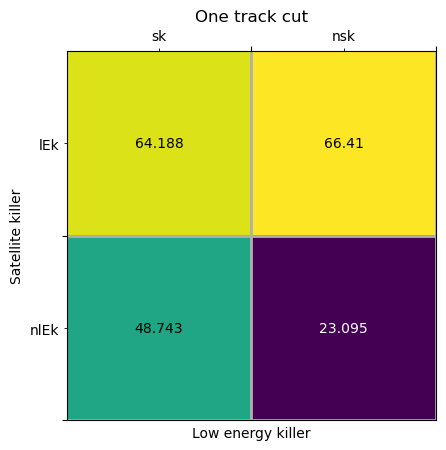

In [109]:
plot_comparisons(data_array, 'One track cut', 'Relative Efficiency', title = 'One track cut', xlabel = 'Low energy killer', ylabel = 'Satellite killer', verbose = False)

201268.0 332380.0
266824.0


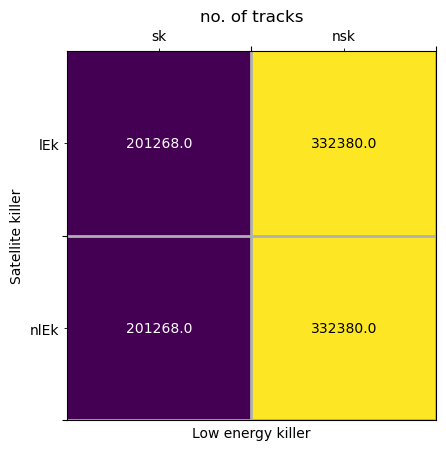

In [110]:
plot_comparisons(data_array, 'trk_no - satellite_no', 'Relative Efficiency', title = 'no. of tracks', xlabel = 'Low energy killer', ylabel = 'Satellite killer', verbose = False)